The problem of predicting one’s illnesses wrongly through self-diagnosis in medicine is very real. In a report by the Telegraph (See Link 1: One in for self), nearly one in four self-diagnose instead of visiting the doctor. Out of those who misdiagnose, nearly half have misdiagnosed their illness wrongly reported (See in link 2: Cyberchondria). While there could be multiple root causes to this problem, this could stem from a general unwillingness and inability to seek professional help.

11% of the respondents surveyed, for example, could not find an appointment in time. This means that crucial time is lost during the screening phase of a medical treatment, and early diagnosis which could have resulted in illnesses treated earlier was not achieved.

With the knowledge of which medical specialty area to focus on, a patient can receive targeted help much faster through consulting specialist doctors. To alleviate waiting times and predict which area of medical specialty to focus on, we can utilize natural language processing (NLP) to solve this task.

Given any medical transcript or patient condition, this solution would predict the medical specialty that the patient should seek help in. Ideally, given a sufficiently comprehensive transcript (and dataset), one would be able to predict exactly which illness he is suffering from.

In [45]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import spacy
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer

nlp = spacy.load('en_core_web_sm')

### Conduct an exploratory data analysis on the dataset.  Report the corpus statistics with appropriate visualization.  Explain clearly why the selected visualization fits your purpose.  

In [83]:
data = pd.read_csv('../data/mtsamples.csv')

num_samples = len(data)
num_medical_specialties = data['medical_specialty'].nunique()
description_lengths = data['description'].str.len()
transcription_lengths = data['transcription'].str.len()

avg_description_length = description_lengths.mean()
min_description_length = description_lengths.min()
max_description_length = description_lengths.max()

avg_transcription_length = transcription_lengths.mean()
min_transcription_length = transcription_lengths.min()
max_transcription_length = transcription_lengths.max()

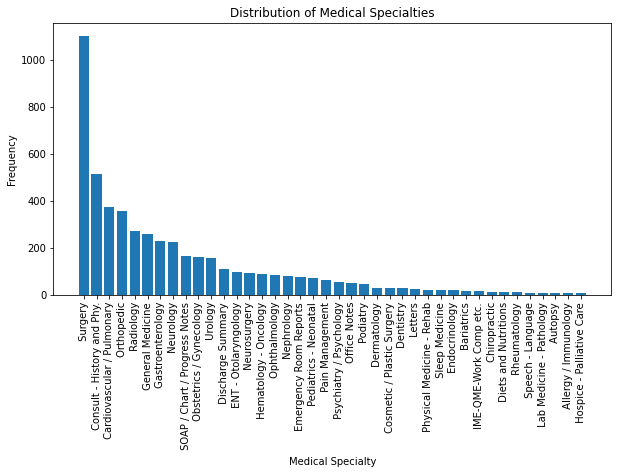

In [104]:
specialty_counts = data['medical_specialty'].value_counts()

plt.figure(figsize = (10, 5))
plt.bar(specialty_counts.index, specialty_counts.values)
plt.xlabel('Medical Specialty')
plt.ylabel('Frequency')
plt.title('Distribution of Medical Specialties')
plt.xticks(rotation = 90)
plt.show()

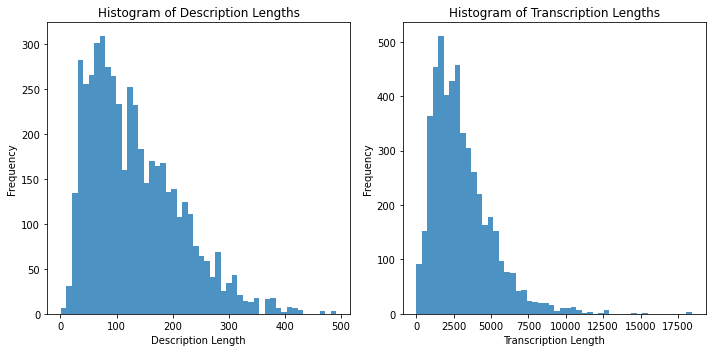

In [103]:
description_lengths   = data['description'].str.len()
transcription_lengths = data['transcription'].str.len()

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].hist(description_lengths, bins = 50, alpha = 0.8)
axs[0].set_xlabel('Description Length')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Description Lengths')

axs[1].hist(transcription_lengths, bins = 50, alpha = 0.8)
axs[1].set_xlabel('Transcription Length')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Transcription Lengths')

plt.tight_layout()
plt.show()

## Datasets, Preprocessing, and Streaming

By default, loading local files creates a DatasetDict object with a train split. We can see this by inspecting the dataset object. This shows us the number of rows and the column names associated with the training set. To enable dataset streaming you just need to pass the <code>streaming = True</code> argument to the <code>load_dataset()</code> function. The streaming mode will ensure that our local device won't have to load the whole dataset at once.

In [87]:
dataset = load_dataset('csv', data_files = '../data/mtsamples.csv', delimiter = '\t')
dataset_sample = dataset['train'].shuffle(seed = 42).select(range(1000))
dataset_sample[:10]

Found cached dataset csv (C:/Users/Renan/.cache/huggingface/datasets/csv/default-3d692acf3d985cae/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Renan\.cache\huggingface\datasets\csv\default-3d692acf3d985cae\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-1f4c04c12388c32d.arrow


{'description,medical_specialty,sample_name,transcription,keywords': [' Medical management, status post left total knee arthroplasty., Orthopedic, Orthopedic Consult ,"REASON FOR CONSULT: , Medical management, status post left total knee arthroplasty.,PAST MEDICAL HISTORY:,1.  Polyarthritis.,2.  Acromegaly.,3.  Hypothyroidism.,4.  Borderline hypertension.,5.  Obesity.,PAST SURGICAL HISTORY: , Hernia repair, resection of tumor, right thumb arthrodesis, carpal tunnel decompression, bilateral hip replacement, right total knee replacement about 2 months ago, open reduction of left elbow fracture.,REVIEW OF SYSTEMS:,CONSTITUTIONAL SYMPTOMS:  No fever or recent general malaise.,ENT:  Not remarkable.,RESPIRATORY:  No cough or shortness of breath.,CARDIOVASCULAR:  The patient denies any heart problems.  No orthopnea.  No palpitations.  No syncopal episodes.,GASTROINTESTINAL:  No nausea.  No vomiting.  No history of GI bleed.,GENITOURINARY:  No dysuria, no hematuria.,ENDOCRINE:  The patient is 

We have loaded our local dataset. But while this worked for the training set, what we really want is to include both the train and test splits in a single DatasetDict object so we can apply Dataset.map() functions across both splits at once. To do this, we can provide a dictionary to the data_files argument that maps each split name to a file associated with that split:

In [92]:
data = pd.read_csv('../data/mtsamples.csv')
shuffle = data.sample(frac = 1, random_state = 42)

train_data,  test_data = train_test_split(shuffle,    test_size = 0.30, random_state = 42)
train_data, valid_data = train_test_split(train_data, test_size = 0.15, random_state = 42) 

train_data.to_csv('../data/train.csv', index = False)
valid_data.to_csv('../data/valid.csv', index = False)
test_data. to_csv('../data/test.csv' , index = False)

data_files = {
    'train': '../data/train.csv',
    'valid': '../data/valid.csv',
    'test' : '../data/test.csv'}

dataset = load_dataset('csv', data_files = data_files, delimiter = '\t', streaming = True)
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x27db02a9b80>,
 'valid': <datasets.iterable_dataset.IterableDataset at 0x27db02a9700>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x27db02a9940>}

In [93]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenized_dataset = dataset.map(lambda x: tokenizer(x['transciption']))
shuffled_dataset = dataset.shuffle(buffer_size = 10_000, seed = 42)
next(iter(shuffled_dataset['train']))

{'description,medical_specialty,sample_name,transcription,keywords': ' Care conference with family at the bedside and decision to change posture of care from aggressive full code status to terminal wean with comfort care measures in a patient with code last night with CPR and advanced cardiac life support., Hospice - Palliative Care, Care Conference With Family ,"REASON FOR FOLLOWUP:,  Care conference with family at the bedside and decision to change posture of care from aggressive full code status to terminal wean with comfort care measures in a patient with code last night with CPR and advanced cardiac life support.,HISTORY OF PRESENT ILLNESS: , This is a 65-year-old patient originally admitted by me several weeks ago with profound hyponatremia and mental status changes.  Her history is also significant for likely recurrent aspiration pneumonia and intubation earlier on this admission as well.  Previously while treating this patient I had met with the family and discussed how aggress

In [94]:
dataset_head = dataset['train'].take(5)
list(dataset_head)

[{'description,medical_specialty,sample_name,transcription,keywords': ' Left Cardiac Catheterization, Left Ventriculography, Coronary Angiography and Stent Placement., Surgery, Cardiac Cath & Coronary Angiography ,"PROCEDURE:,  Left Cardiac Catheterization, Left Ventriculography, Coronary Angiography and Stent Placement.,INDICATIONS: , Atherosclerotic coronary artery disease.,PATIENT HISTORY: , This is a 55-year-old male.  He presented with 3 hours of unstable angina.,PAST CARDIAC HISTORY: , History of previous arteriosclerotic cardiovascular disease.  Previous ST elevation MI.,REVIEW OF SYSTEMS.,  The creatinine value is 1.3 mg/dL mg/dL.,PROCEDURE MEDICATIONS:,1.  Visipaque 361 mL total dose.,2.  Clopidogrel bisulphate (Plavix) 225 mg PO,3.  Promethazine (Phenergan) 12.5 mg total dose.,4.  Abciximab (Reopro) 10 mg IV bolus,5.  Abciximab (Reopro) 0.125 mcg/kg/minute, 4.5 mL/250 mL D5W x 17 mL,6.  Nitroglycerin 300 mcg IC total dose.,DESCRIPTION OF PROCEDURE:,APPROACH: , Left heart cath

### Uses BERT without fine tuning on the LSTM with 50 neurons for the baseline model.  Other hyperparameters are not controlled.   